https://github.com/hayoung-kim/BehavioralCloning-for-Self-Driving-Keras/blob/master/Behavior_Cloning.ipynb

https://github.com/maxritter/SDC-End-to-end-driving

In [1]:
import csv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import glob
import os

In [2]:
# from keras import backend as K
from keras.layers.core import K
# K.clear_session()
# K.set_learning_phase()

Using TensorFlow backend.


In [3]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

# gpu_usage = ['/gpu:0', '/gpu:1']
gpu_usage = '/gpu:0'

# Dataset

In [4]:
import sys
print(sys.version)

3.5.0 |Continuum Analytics, Inc.| (default, Oct 19 2015, 21:57:25) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [5]:
def get_dataset(use_original = True):
    if use_original == True:
        csv_filepath = '../train_img/log.csv'
        img_filepath = '../train_img/Images/'
        splitter = '/'

    # parse data
    lines = []
    with open(csv_filepath) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    
    
    images = []
    steerings = []
    throtles = []
    #for i in range(1,len(lines)):
    for line in lines:
        index = line[0]
        current_path = img_filepath + 'img' + index + '.png'
        image_ = Image.open(current_path)
        image = np.asarray(image_)
        images.append(image)
        steering = float(line[3])
        steerings.append(steering)
        throtle = int(line[1])
        throtles.append(throtle)


    steerings = np.asarray(steerings)
    throtles = np.asarray(throtles)
    images = np.asarray(images)
   
    
    print('data set size: %d' %(len(steerings)))
    
    return images, steerings, throtles

In [6]:
images, steerings, throtles = get_dataset(use_original=True)

print('all dataset is loaded.')
print('data set size: %d' %(len(steerings)))

data set size: 8246
all dataset is loaded.
data set size: 8246


In [44]:
'''
import random
# show example data
ex_image = images[random.randint(0, len(measurements)),:,:,:]
plt.figure()
plt.imshow(ex_image, cmap='gray')
plt.show()

from keras.models import Sequential
from keras.layers import Cropping2D
from keras.layers.core import Reshape

### crop test
model_crop = Sequential()
model_crop.add(Cropping2D(cropping=((40,25), (0,0)), input_shape=(160,320,3)))

cropping_output = K.function([model_crop.layers[0].input], [model_crop.layers[0].output])
cropped_image = cropping_output([ex_image[None,...]])[0]

plt.imshow(cropped_image[0,...]/255, cmap='gray')
plt.show()
print(cropped_image.shape)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-44-ed0b165dc2d6>, line 21)

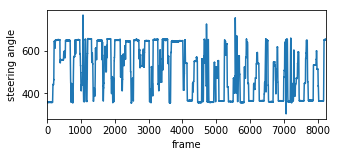

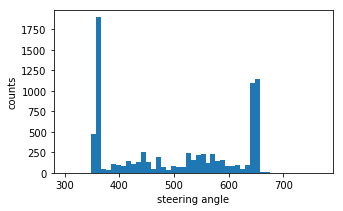

In [7]:
# plot data
plt.figure(figsize=(5,2))
plt.plot(steerings)
plt.xlabel('frame')
plt.ylabel('steering angle')
plt.xlim([0, len(steerings)])

# plot histogram
plt.figure(figsize=(5,3))
plt.hist(steerings, bins=51)
plt.xlabel('steering angle')
plt.ylabel('counts')

# plot!
plt.show()

# Data Adjustment

In [8]:
# Filter the data when moving forward
import random
f_images = images[throtles == 1]
f_steerings = steerings[throtles == 1]

print(f_images.shape)
print(f_steerings.shape)

(7565, 480, 640, 3)
(7565,)


In [9]:
# normalize the steering input

fe_steerings = []

for f_steering in f_steerings:
    # remove outliers
    fe_steering = max(min(f_steering, 650), 350)
    # normalize within range -1,1
    fe_steering = 1 - (13/3) + ((1/150)*fe_steering)
    #save to fe_steering
    fe_steerings.append(fe_steering)

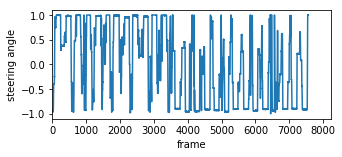

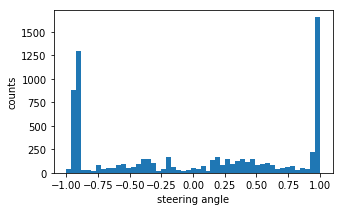

In [10]:
# plot data
plt.figure(figsize=(5,2))
plt.plot(fe_steerings)
plt.xlabel('frame')
plt.ylabel('steering angle')
plt.xlim([0, len(steerings)])

# plot histogram
plt.figure(figsize=(5,3))
plt.hist(fe_steerings, bins=51)
plt.xlabel('steering angle')
plt.ylabel('counts')

# plot!
plt.show()

In [13]:
'''
# image augmentation
augmented_images, augmented_steerings = [], []
for image, measurement in zip(f_images, f_steerings):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    
    # flip
    if measurement != 0:
        augmented_images.append(np.fliplr(image))
        augmented_measurements.append(-measurement)
    
    # 
    
    
augmented_images = np.asarray(augmented_images)
augmented_measurements = np.asarray(augmented_measurements)

print('augmented data is ready.')
print('augmented data size: ', augmented_images.shape[0])

augmented data is ready.
augmented data size:  297


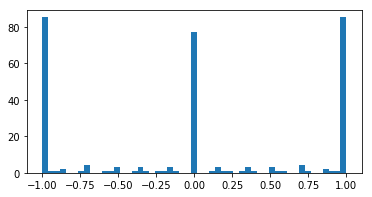

In [14]:
'''
# Histogram of augmented data
plt.figure(figsize=(6,3))
plt.hist(augmented_measurements, bins=51)
plt.show()

In [11]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Activation, Input
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers import Cropping2D
from keras.layers.core import Dropout
from keras.layers.normalization import BatchNormalization

In [12]:
def nvidia_net():
    with K.tf.device(gpu_usage):
        # model setting
        init = 'glorot_normal'
        activation = 'relu'
        keep_prob = 0.5
        keep_prob_dense = 0.7
        
        model = Sequential()
        
        # pre-processing
        #model.add(Cropping2D(cropping=((40,25), (0,0)), input_shape=(480,640,3)))
        #model.add(Lambda(lambda x: K.tf.image.resize_images(x, (66,200)))) # resize image
        #model.add(Input(shape=(480,640,3)) )
        model.add(Cropping2D(cropping=((0,0), (0,0)), input_shape=(480,640,3)))
        model.add(Lambda( lambda x:K.tf.image.resize_images(x, (240,320)) )) # resize image
        model.add(Lambda(lambda x: x/255.0 -0.5)) # normalization
        
        # Convnet
        model.add(Convolution2D(24,5,5, subsample=(2,2), border_mode='valid', init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        model.add(Convolution2D(36,5,5, subsample=(2,2), border_mode='valid', init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        model.add(Convolution2D(48,5,5, subsample=(2,2), border_mode='valid', init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        model.add(Convolution2D(64,3,3, init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        model.add(Convolution2D(64,3,3, init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        # FC
        model.add(Flatten())
        model.add(Dense(100, init=init))
        model.add(Dropout(keep_prob_dense))
        model.add(Dense(50, init=init))
        model.add(Dropout(keep_prob_dense))
        model.add(Dense(10, init=init))
        model.add(Dropout(keep_prob_dense))
        model.add(Dense(1, init=init))
        
        # model.summary
        
        return(model)
        

print('nvidia_net is ready.')
model_n = nvidia_net()
model_n.summary()

nvidia_net is ready.


/home/citlalli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), kernel_initializer="glorot_normal", padding="valid")`
/home/citlalli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), kernel_initializer="glorot_normal", padding="valid")`
/home/citlalli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), kernel_initializer="glorot_normal", padding="valid")`
/home/citlalli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_initializer="glorot_normal")`
/home/citlalli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 480, 640, 3)       0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 240, 320, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 240, 320, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 118, 158, 24)      1824      
_________________________________________________________________
activation_1 (Activation)    (None, 118, 158, 24)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 118, 158, 24)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 77, 36)        21636     
__________

In [13]:
def incpt_mod_nvidia_net(gpu_usage = '/gpu:0'):
    with K.tf.device(gpu_usage):
        # model setting
        init = 'glorot_normal'
        activation = 'relu'
        keep_prob_dense = 0.7
        keep_prob = 0.5
        
        model = Sequential()
        
        ### pre-processing
        model.add(Cropping2D(cropping=((40,25), (0,0)), input_shape=(160,320,3)))
        model.add(Lambda(lambda x: K.tf.image.resize_images(x, (66,200)))) # resize image
        model.add(Lambda(lambda x: x/255.0 -0.5)) # normalization
        
        ### Convnet
        model.add(Convolution2D(24,5,5, subsample=(2,2), border_mode='valid', init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        # 5x5 convolution factorization
#         model.add(BatchNormalization())
        model.add(Convolution2D(36,3,1, init=init))
        model.add(Convolution2D(36,1,3, init=init))
        model.add(Convolution2D(36,3,3, subsample=(2,2), border_mode='valid', init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        # 5x5 factorfization
#         model.add(BatchNormalization())
        model.add(Convolution2D(48,3,1, init=init))
        model.add(Convolution2D(48,1,3, init=init))
        model.add(Convolution2D(48,3,3, subsample=(2,2), border_mode='valid', init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))

        
        # 3x3 factorization
#         model.add(BatchNormalization())
        model.add(Convolution2D(48,3,1, init=init))
        model.add(Convolution2D(64,1,3, init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))

        # 3x3 factorization
#         model.add(BatchNormalization())
        model.add(Convolution2D(48,3,1, init=init))
        model.add(Convolution2D(64,1,3, init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        # average pooling
        model.add(AveragePooling2D(pool_size=(1,6)))
        
        # FC
        model.add(Flatten())
        model.add(Dense(100, init=init))
        model.add(Dropout(keep_prob_dense))
        model.add(Dense(50, init=init))
        model.add(Dropout(keep_prob_dense))
        model.add(Dense(10, init=init))
        model.add(Dropout(keep_prob_dense))
        model.add(Dense(1, init=init))
        
        # model.summary
        
        return(model)
        

print('incpt_mod_nvidia_net is ready.')
model_nm = incpt_mod_nvidia_net()
model_nm.summary()

incpt_mod_nvidia_net is ready.


/home/citlalli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), kernel_initializer="glorot_normal", padding="valid")`
/home/citlalli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (3, 1), kernel_initializer="glorot_normal")`
/home/citlalli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (1, 3), kernel_initializer="glorot_normal")`
/home/citlalli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (3, 3), strides=(2, 2), kernel_initializer="glorot_normal", padding="valid")`
/home/citlalli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 1), kernel_init

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_2 (Cropping2D)    (None, 95, 320, 3)        0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
activation_6 (Activation)    (None, 31, 98, 24)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 29, 98, 36)        2628      
__________

/home/citlalli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:61: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, kernel_initializer="glorot_normal")`
/home/citlalli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:63: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="glorot_normal")`


# Training/Loading

In [14]:
nb_epoch = 300
batch_size = 200
do_train = True

In [15]:
from keras.models import Model, load_model
from keras.optimizers import Adagrad
from keras.callbacks import EarlyStopping, ModelCheckpoint

earlyStopping = EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')

validation_split = 0.2
if do_train == True:
    with K.tf.device(gpu_usage):
#         model = incpt_mod_nvidia_net(gpu_usage)
        model = nvidia_net()
        adagrad = Adagrad(lr=0.005, epsilon=1e-08, decay=0.0)
#         model.compile(loss='mse', optimizer=adagrad)
        model.compile(loss='mse', optimizer='Adagrad')

        history_object = model.fit( f_images, fe_steerings, 
            nb_epoch=nb_epoch, validation_split=validation_split, 
            shuffle=True, batch_size=batch_size)

        model.save('model_origin_martin.h5')
else:
    model = load_model('../model.h5')

/home/citlalli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), strides=(2, 2), kernel_initializer="glorot_normal", padding="valid")`
/home/citlalli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), strides=(2, 2), kernel_initializer="glorot_normal", padding="valid")`
/home/citlalli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), strides=(2, 2), kernel_initializer="glorot_normal", padding="valid")`
/home/citlalli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_initializer="glorot_normal")`
/home/citlalli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API

Train on 6052 samples, validate on 1513 samples
Epoch 1/300
6052/6052 [==============================] - 26s 4ms/step - loss: 14.8393 - val_loss: 0.5873
Epoch 2/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.6041 - val_loss: 0.6072
Epoch 3/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.5984 - val_loss: 0.6164
Epoch 4/300
6052/6052 [==============================] - 21s 4ms/step - loss: 0.6008 - val_loss: 0.6111
Epoch 5/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.6020 - val_loss: 0.6056
Epoch 6/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.5999 - val_loss: 0.6021
Epoch 7/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.6015 - val_loss: 0.6106
Epoch 8/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.5984 - val_loss: 0.6098
Epoch 9/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.5999 - val_loss: 0.6086
Epoch 10/300
60

6052/6052 [==============================] - 22s 4ms/step - loss: 0.3579 - val_loss: 0.2556
Epoch 79/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.3600 - val_loss: 0.2311
Epoch 80/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.3507 - val_loss: 0.2438
Epoch 81/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.3571 - val_loss: 0.2309
Epoch 82/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.3494 - val_loss: 0.2390
Epoch 83/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.3500 - val_loss: 0.2978
Epoch 84/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.3364 - val_loss: 0.2158
Epoch 85/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.3478 - val_loss: 0.2393
Epoch 86/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.3398 - val_loss: 0.2529
Epoch 87/300
6052/6052 [==============================] - 22s 4ms/st

6052/6052 [==============================] - 22s 4ms/step - loss: 0.2853 - val_loss: 0.2221
Epoch 156/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.2947 - val_loss: 0.2398
Epoch 157/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.3022 - val_loss: 0.2267
Epoch 158/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.2925 - val_loss: 0.2219
Epoch 159/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.2902 - val_loss: 0.2178
Epoch 160/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.2984 - val_loss: 0.2178
Epoch 161/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.2853 - val_loss: 0.1923
Epoch 162/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.2844 - val_loss: 0.1902
Epoch 163/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.2864 - val_loss: 0.2345
Epoch 164/300
6052/6052 [==============================] - 2

6052/6052 [==============================] - 22s 4ms/step - loss: 0.2654 - val_loss: 0.1938
Epoch 233/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.2619 - val_loss: 0.2150
Epoch 234/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.2709 - val_loss: 0.2060
Epoch 235/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.2707 - val_loss: 0.2576
Epoch 236/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.2677 - val_loss: 0.1966
Epoch 237/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.2672 - val_loss: 0.2172
Epoch 238/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.2713 - val_loss: 0.2245
Epoch 239/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.2670 - val_loss: 0.2541
Epoch 240/300
6052/6052 [==============================] - 22s 4ms/step - loss: 0.2682 - val_loss: 0.2186
Epoch 241/300
6052/6052 [==============================] - 2

dict_keys(['val_loss', 'loss'])
dict_keys(['val_loss', 'loss'])


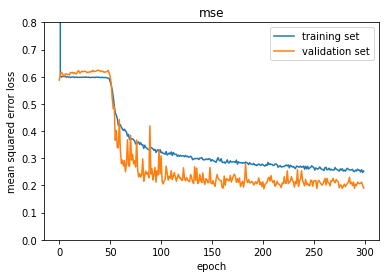

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
history_ = history_object.history
print(history_.keys())
np.save('history_obj_origin.npy', history_)

plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('mse')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.ylim([0, 0.8])
plt.show()

# Make predictions on validation set

In [59]:
# ---------------------- Split dataset into train and validation -----------------------------
# partition the data into training and validation sets using 90% - 20% ratio
from sklearn.model_selection import train_test_split
fe_steerings2 = np.asarray(fe_steerings)

split = train_test_split(list(zip(f_images, fe_steerings)), test_size=0.2, random_state=42)
(X_train, X_val) = split

In [71]:
# Put validation data in numpy arrays for predition
val_images = []
val_steering = []
for i in X_val:
    image = i[0]
    val_images.append(image)
    steering = i[1]
    val_steering.append(steering)

val_images = np.asarray(val_images)
val_steering = np.asarray(val_steering)

print('Total  validation images {}'.format(len(val_images)))

Total  validation images 1513


In [115]:
from time import time
import math

# Make the predictions
t1=time()
pred_steering = model.predict(val_images)
t2=time()

print  ('Took {} sec to predict {} images'.format( (t2-t1), len(val_images) ) )

errors = []
for i in range(0,len(pred_steering)):
    error = abs(pred_steering[i] - val_steering[i])
    #serror = math.pow(error,2)
    errors.append(error)

errors = np.array(errors)

mse = np.mean(errors)
print("ME = {}".format(mse))


Took 3.021862506866455 sec to predict 1513 images
ME = 0.32775914669036865


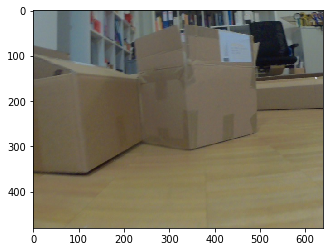

Predicted: [ 0.587322], GT: 0.9800000000000004


In [106]:
# show example data
index = random.randint(0, len(val_images))
#index = 1
ex_image = val_images[index,:,:,:]
plt.figure()
plt.imshow(ex_image, cmap='gray')
plt.show()

print('Predicted: {}, GT: {}'.format(pred_steering[index], val_steering[index]))


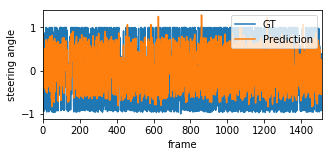

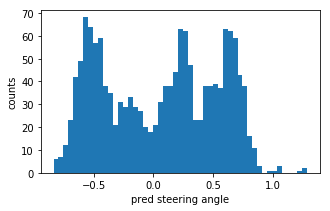

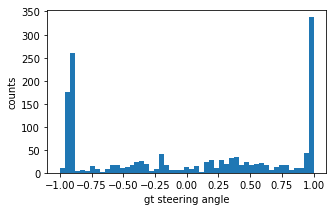

In [130]:
# Plot the predicted steering agains the GT
plt.figure(figsize=(5,2))
plt.plot(val_steering, label='GT')
plt.plot(pred_steering, label='Prediction')
plt.xlabel('frame')
plt.ylabel('steering angle')
plt.xlim([0, len(val_steering)])
plt.legend()

# plot histogram
plt.figure(figsize=(5,3))
plt.hist(pred_steering, bins=51)
plt.xlabel('pred steering angle')
plt.ylabel('counts')

plt.figure(figsize=(5,3))
plt.hist(val_steering, bins=51)
plt.xlabel('gt steering angle')
plt.ylabel('counts')

# plot!
plt.show()

In [ ]:
K.clear_session()

# Read the test dataset

In [116]:
def get_test_dataset(use_original = True):
    if use_original == True:
        csv_filepath = '../test_img/log.csv'
        img_filepath = '../test_img/'
        splitter = '/'

    # parse data
    lines = []
    with open(csv_filepath) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
    
    
    images = []
    steerings = []
    throtles = []
    #for i in range(1,len(lines)):
    for line in lines:
        index = line[0]
        current_path = img_filepath + 'img' + index + '.png'
        image_ = Image.open(current_path)
        image = np.asarray(image_)
        images.append(image)
        steering = float(line[3])
        steerings.append(steering)
        throtle = int(line[1])
        throtles.append(throtle)


    steerings = np.asarray(steerings)
    throtles = np.asarray(throtles)
    images = np.asarray(images)
   
    
    print('data set size: %d' %(len(steerings)))
    
    return images, steerings, throtles

In [117]:
test_images, test_steerings, test_throtles = get_test_dataset(use_original=True)

print('all dataset is loaded.')
print('Test data set size: %d' %(len(test_steerings)))

data set size: 1195
all dataset is loaded.
Test data set size: 1195


In [118]:
# Filter the data when moving forward
import random
f_test_images = test_images[test_throtles == 1]
f_test_steerings = test_steerings[test_throtles == 1]

print(f_test_images.shape)
print(f_test_steerings.shape)


# normalize the steering input
fe_test_steerings = []

for f_test_steering in f_test_steerings:
    # remove outliers
    fe_test_steering = max(min(f_test_steering, 650), 350)
    # normalize within range -1,1
    fe_test_steering = 1 - (13/3) + ((1/150)*fe_test_steering)
    #save to fe_steering
    fe_test_steerings.append(fe_test_steering)

(1106, 480, 640, 3)
(1106,)


In [121]:
# Make the predictions
t1=time()
pred_test_steering = model.predict(f_test_images)
t2=time()

print  ('Took {} sec to predict {} images'.format( (t2-t1), len(f_test_images) ) )

errors = []
for i in range(0,len(pred_test_steering)):
    error = abs(pred_test_steering[i] - fe_test_steerings[i])
    #serror = math.pow(error,2)
    errors.append(error)

errors = np.array(errors)

mse = np.mean(errors)
print("ME = {}".format(mse))

Took 2.4939022064208984 sec to predict 1106 images
ME = 0.49216824769973755


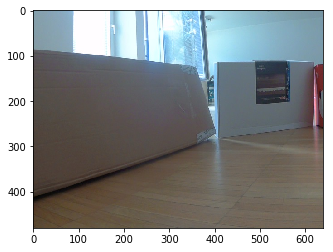

Predicted: [ 0.25748628], GT: 0.9600000000000009


In [128]:
# show example data
index = random.randint(0, len(f_test_images))
#index = 1
ex_image = f_test_images[index,:,:,:]
plt.figure()
plt.imshow(ex_image, cmap='gray')
plt.show()

print('Predicted: {}, GT: {}'.format(pred_test_steering[index], fe_test_steerings[index]))

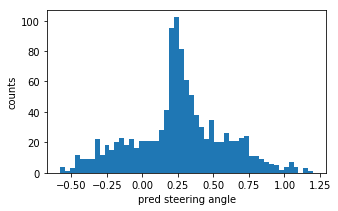

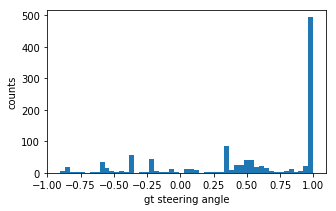

In [129]:
# plot histogram
plt.figure(figsize=(5,3))
plt.hist(pred_test_steering, bins=51)
plt.xlabel('pred steering angle')
plt.ylabel('counts')

plt.figure(figsize=(5,3))
plt.hist(fe_test_steerings, bins=51)
plt.xlabel('gt steering angle')
plt.ylabel('counts')

# plot!
plt.show()